# Spiking Neural  Network (SNN): A probabilistic Model
> In the notebook, we add a cross feedback between two neurons.
You can find the introduction in the [notebook.1](./notebook.1.fully.obseverd.models.ipynb) .

# Loading packages

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import bernoulli
from multiprocessing import Pool
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings("ignore")

# USPS dataset

> USPS dataset, "usps.h5", is a _h5_ formated file and we us "h5py" package to load it. We assume it is saved in the current directory. Here, we load the train and test sets separately with their corresponding labels.

In [2]:
import h5py
with h5py.File('usps.h5', 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

# Ones and sevens

### 500 training, 125 testing

> To test the accuracy of the following SNN classifier, the train and test set restricts to ones and sevens. In addition, similar to [[1]](https://arxiv.org/pdf/1910.01059.pdf), we use the first 500 cases from the train set and 125 cases from the test set. These choices allow us to compare the final accuracy with the reported one in [[1]](https://arxiv.org/pdf/1910.01059.pdf).

In [3]:
# Restricted train set
y2_tr = y_tr[(y_tr == 1) | (y_tr == 7)][:500]
# Restricted train labels
X2_tr = X_tr[(y_tr == 1) | (y_tr == 7),:][:500]
# Restricted test set
y2_te = y_te[(y_te == 1) | (y_te == 7)][:125]
# Restricted test labels
X2_te = X_te[(y_te == 1) | (y_te == 7),:][:125]

# Global parameters

In [4]:
# Number of output neoruns
neuron_numbers = 2
# Number of basis in forward filter
K = 12
# Spikes maximum steps
T = 32
# Rate encoding in Hz
Freq = 3
# Train set size
train_size = X2_tr.shape[0]
# Number of pixels in an image
image_size = X2_tr.shape[1]
# Test set size
test_size = X2_te.shape[0]

# Rate encoding

> Before directly clamping the images to the network inputs, we encode the USPS dataset by using  the _rate encoding_, denotes as "Freq", and defined in the above cell. 

> Each gray pixel is converted into an input spiking signal by generating an independent identically distributed (i.i.d.) Bernoulli vector of T samples, with the spiking probability takes as proportional to the pixel intensity. Besides, the probability is limited to be between zero and 0.5.

In [5]:
# For each 16 x 16 image, we need a 256 x T array to fill it with an iid sampled vector
trainset = np.zeros((train_size, image_size, T))
train_y = np.zeros((neuron_numbers, train_size, T))

for image_index in range(train_size):
    ############################################################
    #
    #    Train set lables
    #
    # Note: 1) We fill the true labels with a frequency of spikes
    #       denotes as Freq in Hz
    #       2) False labels are zero arrays
    if y2_tr[image_index] == 1:
        train_y[0, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    else:
        train_y[1, image_index, :] = np.array([ 1 if(i%Freq==0) else 0 for i in range(0, T)])
    ############################################################
    #
    #    Train set images
    #    
    image = X2_tr[image_index,:]    
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        # Note: Image intesity is divided by 2 to keep the probability in [0, 0.5]
        trainset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)        
        
testset = np.zeros((test_size, image_size, T))
for image_index in range(test_size):
    ############################################################
    #
    #    Test set images
    #   
    image = X2_te[image_index,:]
    for pixel_index in range(image_size):
        # For each pixel, the pixel intensity defines the sampling probability
        # Note: Image intesity is divided by 2 to keep the probability in [0, 0.5]
        testset[image_index, pixel_index, :] = bernoulli.rvs(image[pixel_index]/2, size=T)            

# Defining helper functions

In [6]:
def sigmoid(x):
    return np.array(1/(1+np.exp(-x)))

def convolution(f_t, g_t):
    ''' See eq. (4) below
    '''
    return np.dot(f_t, g_t[::-1])

# Filter Kernels

### Raised Cosine Kernels
> We use the cosin basis that are explianed in [[3]
](https://www.nature.com/articles/nature07140).

> Note that the time domian is in logarithmic scale. So, "this basis allows for the representation of fine temporal structure near the time of a spike and coarser/smoother dependency at later times"[[3]](https://www.nature.com/articles/nature07140)

In [7]:
cosin_basis = np.zeros((K, T))
for k in range(K):    
    cosin_basis[k, :] = np.cos(np.log(-k/2 + 7*np.pi/6 + (2*np.arange(0, T)-T)*np.pi/(T)))
    # Negative values replaces by zero
    cosin_basis[k, cosin_basis[k, :] < 0 ] = 0    
    # We make sure the support of the filter is one and only one segment
    if k > 1 :
        cosin_basis[k, :(k+4)] = 0
    # Make sure there is non Nan in the array and replace them
    # by zero
    cosin_basis[k, :] = np.nan_to_num(cosin_basis[k, :])

# Feedback Exponential Kernel

> An exponential feedback filter, as it was explained in [[1]](https://arxiv.org/pdf/1910.01059.pdf),  controls the immediate capability of spiking of a neuron.  

> Mathematically, it defines as $-\exp(-t/t_m)$ where $t_m$ denotes the scale length for exponential decay along the time domain. Here, we take $t_m = T/8$, where $T = 32$ is the maximum time steps in the simulation.

> Finally, the filter plot and its convolution with repect to a sequence of spikes are depicted.

In [8]:
# Time scale
T_m = T/8
# Filter's array
exp_basis = np.zeros(T)
for t in range(T):
    exp_basis[t] = -np.exp(-t/T_m)

# NN topology: No Hidden Layer

> We add a feedback from the other neuron, to inhibit the neuron firing rate. The inhibition only happens for the time that one neuron is firing. This is useful for a classification problem. This is depicted schematically in the blow diagram.

![Network Diagram](./diagrams/network_draw_io_2.svg)

## Memberane potential, $u_{i, t}$ at time $t$:

## $u_{i, t} = \sum_{j \in \mathcal{P_j}} \omega_{j, i} \overrightarrow{s}_{j, t-1} + \omega_i \overleftarrow{s}_{i, t-1} + \omega'_i \overleftarrow{s}_{i+1, t-1} + \gamma_i  \;\;\;\;\;\;\;\;\;\;\;\;\;$ (1)         

## where 
1. $\mathcal{P_j}$ is the set of pre-synaptic inputs for the neuron $i$.
2. $\omega_{j, i}$  is the feedforward weight for the input $j$ to the neuron $i$.
3. $\omega_i$ is the feedback weight for the neuron $i$.
4. $\gamma_i$ is the bias parameter.
5. $\overrightarrow{s}_{j, t-1} = a_t * s_{j, t-1}$ for feedforward filter basis $a_t$ (2).
6. $\overleftarrow{s}_{i, t-1} = b_t * s_{j, t-1}$ for feedback filter basis $b_t$ (3).
7. $f_t * g_t = \sum_{\delta \ge 0} f_{\delta} g_{t - \delta}$ is a convolution operator (4).

# Learning by Maximum log-likelihood estimation ([[1]](https://arxiv.org/pdf/1910.01059.pdf))

### Because of linearity of GLM, the gradiant of the log-liklihood w.r.t. parameter $\boldsymbol{\omega'_i}$ for neuron $i$ is similar to $\boldsymbol{\omega_i}$



### $\nabla_{\omega'_{i,j}} \log P_{\boldsymbol{\theta_i}}  (s_{i} | \boldsymbol{s}_{\mathcal{P}_{i} \cup \{i\}, \le t-1}) = \overleftarrow{s}_{i+1, t-1}(s_{i,t} - \sigma(u_{i+1, t})),   \;\;\;\;\;\;\;\;\;\;\;\;\;$(9)



# Neuron Class:
> This class is the same as the one defined in [Notebook 1](notebook.1.fully.obseverd.models.ipynb), except it includes the cross feedback from the second neuron. We do not implement the faster methods here.

In [9]:
class Neuron:
    def __init__(self, image_size, K, T, 
                 forward_basis, feedback_basis, cross_feedback_basis,
                 prob_threshold = .5):
        ''' Create a new instance of a Neuron object.
        
            image_size (integer): The size of an image array
            K (integer): Number of forward filter basis.
            T (integer): Maximum number of time steps
            forward_basis (np array): Pre-synoptic filter basis
            feedback_basis (np array): Post-synoptic filter basis
            prob_threshold (default 0.5): 
                 The threshold above which the neuron
                 fires and spike.                                   
        '''
        self.image_size = image_size
        self.K = K
        self.T = T
        self.prob_threshold = prob_threshold
        
        if len(feedback_basis.shape) == 1:
            self.feedbacks_K = 1
        else:
            self.feedbacks_K = K
        
        # Initialise weigths by sampling from Uniform(-1, 1)
        self.synaptic_ws = np.random.uniform(-1, 1, (image_size,  K))
        self.feedback_ws = np.random.uniform(-1, 1,  self.feedbacks_K)                    
        self.cross_feedback_ws = np.random.uniform(-1, 1)
        self.gamma = np.random.uniform(-1, 1)
        # Store filter basis
        self.forward_basis = forward_basis
        self.feedback_basis = feedback_basis
        self.cross_feedback_basis = cross_feedback_basis
        # The inversion that is required for the convolusion is
        # time consuming in each SGD step. So, we construct an inversed
        # tensor now, and call it later, to achieve better performance 
        self.fast_forward_basis = np.zeros((K, T, T))
        for k in range(K):
            for t in range(1, T+1):
                segment = forward_basis[k, :t]
                self.fast_forward_basis[k, t-1, :t] = segment[::-1]
        #############################################
        # Internal states      
        #
        
        # This matrix stores $s_{j, t-1}$ in eq. (2)
        self.s_forward_t_1_s = np.zeros((image_size, K))
        # This value/array stores $s_{j, t-1}$ in eq. (3)
        if self.feedbacks_K == 1:
            self.s_feedback_t_1_s = np.zeros(1)        
        else:
            self.s_feedback_t_1_s = np.zeros(self.feedbacks_K) 
        # Previous spikes             
        self.previous_spikes = np.zeros(self.T +1)
        
        
           
    def output(self, image, t, cross_spikes_t_1):
        ''' This method returns the membrane potential
            and changes the internal states of the neuron.
            
            Note: This method is for demonstration only. No performance
                  consideration is included here.
            
            image (np array (image_size x T)): The encoded image matrix
            t (integer): Time is zero based, so, t referes to the current
                         time and must start from 1.
            , cross_spikes_t_1 (np array (t-1)): The other neorun spikes
        '''        
        # loop over filter basis
        for k in range(self.K):
            # loop over the pixels
            for j in range(self.image_size):
                spikes = image[j, :t]                    
                # contribution from j input                                          
                # Convolution, see eq. (2)
                self.s_forward_t_1_s[j, k] = convolution(self.forward_basis[k, :t], spikes)
                # Check the validity of the outputs
                if np.isnan(self.s_forward_t_1_s[j, k]):
                    print(f"NAN s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                if np.isinf(self.s_forward_t_1_s[j, k]):
                    print(f"Inf s_forward i={self.i}, j={j}, k={k}")
                    raise ValueError
                    
            # At time t = 1, we take the previous spike as zero
            # So, the feedback is zero too.
            if self.feedbacks_K > 1:
                # Feedback contribution
                # The array previous_spikes contains the history of pulses that
                # has been emitted from the neorun.
                # Convolution, see eq. (3)
                self.s_feedback_t_1_s[k] = convolution(self.feedback_basis[k, :t], self.previous_spikes[:t])  
        
        # At time t = 1, we take the previous spike as zero
        # So, the feedback is zero too.                        
        if self.feedbacks_K ==1:
            # Feedback contribution
            # The array previous_spikes contains the history of pulses that
            # has been emitted from the neorun.
            # Convolution, see eq. (1) 
            self.s_feedback_t_1_s = convolution(self.feedback_basis[:t], self.previous_spikes[:t]) 
            
        #######################################
        #
        # Cross feedback contribution
        #
        self.s_cross_feedback_t_1_s = convolution(self.cross_feedback_basis[:t], cross_spikes_t_1) 
            
        # Calculating membrane potential
        # This is the sum of contributions from
        # inputes, feedback and bias.
        # See eq. (1)
        u_i = (
               np.sum(self.synaptic_ws*self.s_forward_t_1_s)
             + np.sum(self.feedback_ws*self.s_feedback_t_1_s) 
             + self.cross_feedback_ws*self.s_cross_feedback_t_1_s
             + self.gamma
        )
        # Check the validity of u_i
        if np.isinf(u_i):
            print(f"Inf u_i i={self.i}")
            raise ValueError 
        
        # According to the value of sigmoid(u_i) and spike threshold,
        # the neuron fires. We store this internal state in  previous_spikes array.
        # In the next time step, we use it to find the convolution of the feedback signal.
        self.previous_spikes[t] = 1 if sigmoid(u_i) >= self.prob_threshold else 0
           
        return (u_i, self.previous_spikes[:(t+1)])
    
    def gradiant(self, s_i, image, t, cross_spikes_t_1):
        ''' The gradiant method moves the internal state
            one step forward, while it returns the gradiants
            with respect the weights
            
            s_i (0 or 1): the true label at time t.
            image (np array (image_size x T)): The encoded image matrix
            t (integer): Time is zero based, so, t referes to the current
                         time and must start from 1. 
        '''
        # Eq. (6)        
        u_i, spikes = self.output(image, t, cross_spikes_t_1)
        diff = s_i - sigmoid(u_i)          
        g_bias = diff            
        # Eq. (7)
        g_synaptic_ws = self.s_forward_t_1_s*diff        
        # Eq. (8)
        g_feedback_ws = self.s_feedback_t_1_s*diff
        # 
        g_cross_feedback_ws = self.s_cross_feedback_t_1_s*diff
        
        return (g_bias, g_synaptic_ws, g_feedback_ws, g_cross_feedback_ws, spikes)
    
    def memb(self, image):
        ''' Returns neorun's membrane potential for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        self.previous_spikes = np.zeros(self.T +1)
        return np.array([self.output(image, t) for t in range(1, self.T)])
    
    def probs(self, image): 
        ''' Returns neorun's probability of firing an spike for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return sigmoid(self.memb(image))
    
    def spikes(self, image):
        ''' Returns neorun's spikes for 
            all time steps.
            
            image (np array (image_size x T)): The encoded image matrix
        '''
        return np.where(self.probs(image) >= self.prob_threshold, 1, 0)
    
    

# Helper method

> The following method simplifies the instantiation of a neuron class.

In [10]:
def init_ws(image_size, K, T, cosin_feedback = True, seed=44):
    if seed is not None:
        np.random.seed(seed)    
    
    def init_neuron_cosine(i):
        '''Create a single neuron with
           inversed cosin basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      cosin_basis, -cosin_basis, exp_basis)
    
    def init_neuron_exp(i):
        '''Create a single neuron with
           exp basis for feedback
        '''
        return Neuron(image_size, K, T, 
                      cosin_basis, exp_basis, exp_basis)
    if cosin_feedback:
        return init_neuron_cosine
    else:
        return init_neuron_exp



# Now, we overfit the model for a single image

> To check the code and its overal behaviour, it is usefull to overfit the model for a single image. Training the model for a long enough epoch results in an overfitted model that must reproduce the exact output similar to the true label in the training phase.

> The result is a kind of assurance that every bits and pieces of the code works properly and smoothly.

In [11]:
init_neuron = init_ws(image_size, K, T, cosin_feedback = False, seed=43)


image_index = 0

image = trainset[image_index, :, :]         
label = train_y[:, image_index, :] 

eta = 0.5
max_epoch = 400
Error_S = np.zeros((2, max_epoch))
network = [None, None]

neuron1 = init_neuron(0)
network[0] = neuron1
neuron2 = init_neuron(1)
network[1] = neuron2


for epo in range(max_epoch):
    
    spikes = [[0], [0]]
    
    for t in range(1, T):
        if t == 1:
            g_bias_1, g_synaptic_ws_1, g_feedback_ws_1, g_cross_feedback_ws_1, spikes_1 =  neuron1.gradiant(label[0, t-1], image, t, spikes[1])
        
            g_bias_2, g_synaptic_ws_2, g_feedback_ws_2, g_cross_feedback_ws_2, spikes_2 =  neuron2.gradiant(label[1, t-1], image, t, spikes[0])
        else:
            g_bias_12, g_synaptic_ws_12, g_feedback_ws_12, g_cross_feedback_ws_12, spikes_1 =  neuron1.gradiant(label[0, t-1], image, t, spikes[1])
            g_bias_1 += g_bias_12
            g_synaptic_ws_1 += g_synaptic_ws_12
            g_feedback_ws_1 += g_feedback_ws_12
            g_cross_feedback_ws_1 += g_cross_feedback_ws_12
            g_bias_22, g_synaptic_ws_22, g_feedback_ws_22, g_cross_feedback_ws_22, spikes_2 =  neuron2.gradiant(label[1, t-1], image, t, spikes[0])
            g_bias_2 += g_bias_22
            g_synaptic_ws_2 += g_synaptic_ws_22
            g_feedback_ws_2 += g_feedback_ws_22
            g_cross_feedback_ws_2 += g_cross_feedback_ws_22
        
        spikes = [spikes_1, spikes_2]

        Error_S[0, epo] += np.sum(g_bias_1**2)        
        Error_S[1, epo] += np.sum(g_bias_2**2)
        
    neuron1.gamma += eta*g_bias_1/(epo+1)
    neuron1.synaptic_ws += eta*g_synaptic_ws_1/(epo+1)
    neuron1.feedback_ws += eta*g_feedback_ws_1/(epo+1) 
    neuron1.cross_feedback_ws += eta*g_cross_feedback_ws_1/(epo+1) 

    neuron2.gamma += eta*g_bias_2/(epo+1)
    neuron2.synaptic_ws += eta*g_synaptic_ws_2/(epo+1)
    neuron2.feedback_ws += eta*g_feedback_ws_2/(epo+1) 
    neuron2.cross_feedback_ws += eta*g_cross_feedback_ws_2/(epo+1) 

  
                

# Check the output of the trained model

> We feed the signle image that we used to train the model, for demonstration purpose (It never happens in real modelling). We expect to get the same rate encoding frequecny for the true case and zero for the false one

In [12]:
def spikes_output(image, n1, n2):
    spikes = [[0], [0]]
    
    for t in range(1, T):
        _ , spikes_1 = n1.output(image, t, spikes[1])
        _ , spikes_2 = n2.output(image, t, spikes[0])
        
        spikes = [spikes_1, spikes_2]
    return (spikes[0], spikes[1])

In [13]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

str_first = "first"
str_second = "second"
print(f"Label: {y2_tr[image_index]}, so the { str_first if(y2_tr[image_index] == 1) else str_second}" 
      f" neuron predicts the True rate.")
#print(f"The rate encoding that we used for training model: {(1/p):.3f}")
print(f"The rate encoding that we used for first : {np.mean(moving_average(label[0,:], Freq)):.3f}")
print(f"The rate encoding that we used to train the model: {np.mean(moving_average(label[1,:], Freq)):.3f}")

n1 = network[0]
n2 = network[1]


n1_spikes, n2_spikes = spikes_output(image, n1, n2)

n1_pred = np.sum(n1_spikes)/len(n1_spikes)
n2_pred = np.sum(n2_spikes)/len(n2_spikes)

print(f"The moving average rate encoding of the first neuron output: {np.mean(moving_average(n1_spikes, Freq)):.3f}")
print(f"The moving average rate encoding of the second neuron output: {np.mean(moving_average(n2_spikes, Freq)):.3f}")

print(f"The average rate encoding of the first neuron output: {n1_pred:.3f}")
print(f"The average rate encoding of the second neuron output: {n2_pred:.3f}")

Label: 7, so the second neuron predicts the True rate.
The rate encoding that we used for first : 0.000
The rate encoding that we used to train the model: 0.333
The moving average rate encoding of the first neuron output: 0.000
The moving average rate encoding of the second neuron output: 0.333
The average rate encoding of the first neuron output: 0.000
The average rate encoding of the second neuron output: 0.344


# Global error during the learning 

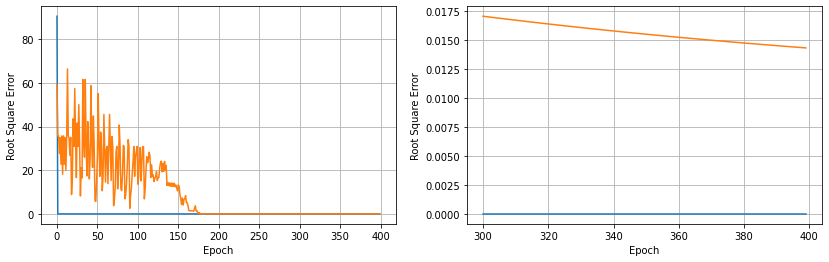

In [14]:
fig = plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.plot(np.sqrt(Error_S[0,:]))
plt.plot(np.sqrt(Error_S[1,:]))
plt.xlabel("Epoch")
plt.ylabel("Root Square Error")
plt.grid()
plt.subplot(122)
plt.plot(np.sqrt(Error_S[0,300:]))
plt.plot(np.sqrt(Error_S[1,300:]))
plt.xlabel("Epoch")
plt.ylabel("Root Square Error")
plt.xticks(ticks=[i*20  for i in range(6)] , labels=[i*20 + 300 for i in range(6)])
plt.grid()
plt.show()

# Spike outputs

> And the outputs of the neurons.

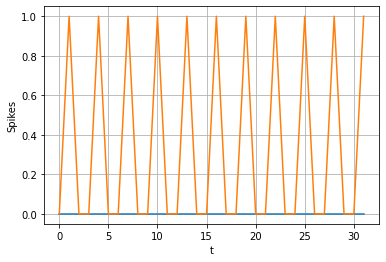

In [15]:
n1 = network[0]
n2 = network[1]

n1_spikes, n2_spikes = spikes_output(image, n1, n2)

plt.plot(n1_spikes)
plt.plot(n2_spikes)
plt.ylabel("Spikes")
plt.xlabel("t")
plt.grid()
plt.show()


# Reference 

### An Introduction to Probabilistic Spiking Neural Networks: [[1]](https://arxiv.org/pdf/1910.01059.pdf)

### USPS dataset: [[2]](https://www.kaggle.com/bistaumanga/usps-dataset)

### Spatio-temporal correlations and visual signalling in a complete neuronal population: [[3]](https://www.nature.com/articles/nature07140)